# Refinement with bumps-dream PbSO4

In [1]:
# esyScience, technique-independent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_context('notebook')

# esyScience, diffraction
from easyDiffractionLib import Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.elements.Backgrounds.Point import PointBackground, BackgroundPoint
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams

from easyCore.Fitting.Fitting import Fitter

GSAS-II binary directory: /home/erikfr/.local/lib/python3.8/site-packages/GSASII/bindist
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build


In [2]:
# help functions

def print_parameters(job):
    print(job.phases[0].scale)
    print(job.pattern.zero_shift)
    print(job.parameters.resolution_u)
    print(job.parameters.resolution_v)
    print(job.parameters.resolution_w)
    print(job.backgrounds[0][0])
    print(job.backgrounds[0][1])
    

def compute_rmse(y1, y2):
    delta_y = y1-y2
    rmse = np.sqrt(np.mean(delta_y**2))
    return rmse

In [3]:
# load cif
cif_fname = '../data/PbSO4.cif'
phases = Phases.from_cif_file(cif_fname)
phase = phases[0]

# load diffraction data
meas_fname = '../data/D1A@ILL.xye'
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)
print(meas_x.shape, meas_y.shape)

(2201,) (2201,)


In [4]:
# setup interface to CrysFML and job
calculator = Calculator(interface_name='CrysPy')
job = Job(phases=phases, interface=calculator)

Temp CIF: /tmp/easydiffraction_temp.cif


In [5]:
# setup 
job.parameters.wavelength = 1.912

# add background
bkg = PointBackground(linked_experiment='PbSO4')
bkg.append(BackgroundPoint.from_pars(meas_x[0], 200))
bkg.append(BackgroundPoint.from_pars(meas_x[-1], 250))
job.set_background(bkg)

# set which parameters to refine
job.pattern.scale.fixed = True
job.phases[0].scale.fixed = False
job.pattern.zero_shift.fixed = False
job.parameters.resolution_u.fixed = False
job.parameters.resolution_v.fixed = False
job.parameters.resolution_w.fixed = False
job.backgrounds[0][0].y.fixed = False
job.backgrounds[0][1].y.fixed = False

# set reasonable initial parameter values
job.pattern.zero_shift = 0.125
job.parameters.resolution_u = 0.17
job.parameters.resolution_v = -0.38
job.parameters.resolution_w = 0.4
job.backgrounds[0][0] = 218
job.backgrounds[0][1] = 230


print('Initial parameters')
print_parameters(job)
print(job.get_fit_parameters())

Initial parameters
<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>
<Parameter 'zero_shift': 0.125+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_u': 0.17+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.38+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.4+/-0, bounds=[-inf:inf]>
<BackgroundPoint '10,0_deg': 200.0+/-0, bounds=[-inf:inf]>
<BackgroundPoint '120,0_deg': 250.0+/-0, bounds=[-inf:inf]>
[<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>, <Parameter 'resolution_u': 0.17+/-0, bounds=[-inf:inf]>, <Parameter 'resolution_v': -0.38+/-0, bounds=[-inf:inf]>, <Parameter 'resolution_w': 0.4+/-0, bounds=[-inf:inf]>, <Parameter 'zero_shift': 0.125+/-0, bounds=[-inf:inf]>, <Parameter 'intensity': 200.0+/-0, bounds=[-inf:inf]>, <Parameter 'intensity': 250.0+/-0, bounds=[-inf:inf]>]


Initial RMSE: 70.1800916332574
[200.05681818 200.07954545 200.10227273 ... 267.55966248 276.31576712
 290.51558237]


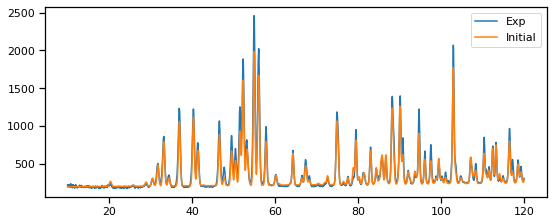

In [6]:
# Initial before fit
y_initial = calculator.fit_func(meas_x)
rmse_initial = compute_rmse(meas_y, y_initial)
print('Initial RMSE:', rmse_initial)
print(y_initial)
fig = plt.figure(figsize=(9, 3.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_initial, label='Initial')
plt.legend()

In [7]:
# setup fitting
fitter = Fitter(job, calculator.fit_func)
fitter.switch_engine('bumps')
print(job.get_fit_parameters())

[<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>, <Parameter 'resolution_u': 0.17+/-0, bounds=[-inf:inf]>, <Parameter 'resolution_v': -0.38+/-0, bounds=[-inf:inf]>, <Parameter 'resolution_w': 0.4+/-0, bounds=[-inf:inf]>, <Parameter 'zero_shift': 0.125+/-0, bounds=[-inf:inf]>, <Parameter 'intensity': 200.0+/-0, bounds=[-inf:inf]>, <Parameter 'intensity': 250.0+/-0, bounds=[-inf:inf]>]


In [8]:
# bumps-dream fit

# parameters
steps = 500
burn = 50
thin = 1
pop = 1

# weights
weights = np.sqrt(meas_y)  # uncertainty in bumps (dy)

print(meas_x.shape, meas_y.shape, weights.shape)

# run
kwargs = dict(samples=1000000, steps=steps, burn=burn, thin=thin, pop=pop, alpha=0.0001,
              outliers='none', trim=False)

result = fitter.fit(meas_x, meas_y, weights=weights, method='dream', **kwargs)

(2201,) (2201,) (2201,)
# steps: 500, # draws: 3500


In [9]:
# print refined parameters
print_parameters(job)

<Parameter 'scale': 1.208+/-0.009, bounds=[0:inf]>
<Parameter 'zero_shift': 0.1224+/-0.0009, bounds=[-inf:inf]>
<Parameter 'resolution_u': 0.198+/-0.027, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.49+/-0.06, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.485+/-0.032, bounds=[-inf:inf]>
<BackgroundPoint '10,0_deg': 196.9+/-1.5, bounds=[-inf:inf]>
<BackgroundPoint '120,0_deg': 240.0+/-3.4, bounds=[-inf:inf]>


Refined RMSE: 46.473155516401725


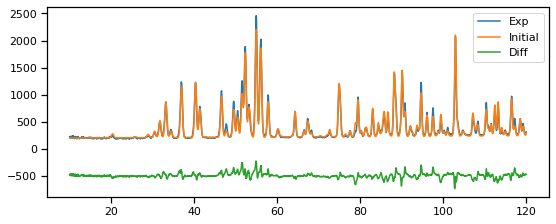

In [10]:
# refined result
y_refined = calculator.fit_func(meas_x)
rmse_refined = compute_rmse(meas_y, y_refined)
print('Refined RMSE:', rmse_refined)

fig = plt.figure(figsize=(9, 3.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_refined, label='Initial')
plt.plot(meas_x, meas_y - y_refined-500, label='Diff')
plt.legend()

In [11]:
# extract MCMC-results
from bumps.dream.stats import var_stats

steps, samples, logp = result.engine_result.state.chains()
state = result.engine_result.state


# analyze
params = state.best()[0]
n_parameters = len(params)

draw = state.draw()
vstats = var_stats(draw)
stderrs = np.array([(v.p68[1] - v.p68[0]) / 2 for v in vstats], 'd')


names = ['scale', 'zero_shift', 'resolution_u', 'resolution_v', 'resolution_w', 'intensity', 'intensity']


def print_all_params(names, values, errs):
    for n, v, e in zip(names, values, errs):
        print(f'{n:15} {v:12.5f} , err {e:8.5f}')

print_all_params(names, params, stderrs)


samples = samples[:, :, :]
samples_flat = samples.reshape(-1, n_parameters)

scale               -0.48530 , err  0.05850
zero_shift           0.48496 , err  0.03158
resolution_u       239.99814 , err  3.44376
resolution_v         1.20847 , err  0.00902
resolution_w       196.92294 , err  1.50350
intensity            0.12237 , err  0.00091
intensity            0.19811 , err  0.02655


(511, 7, 7)


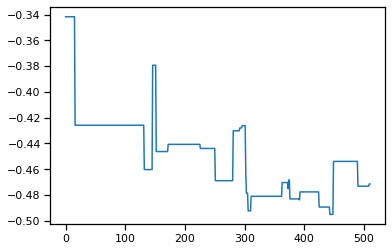

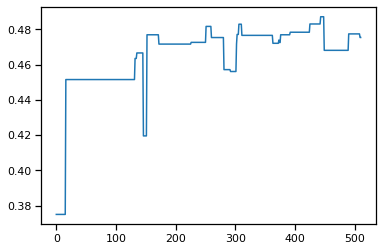

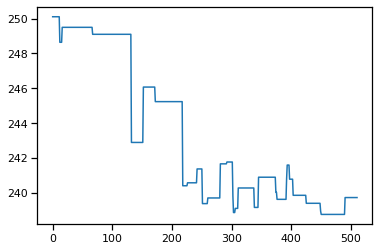

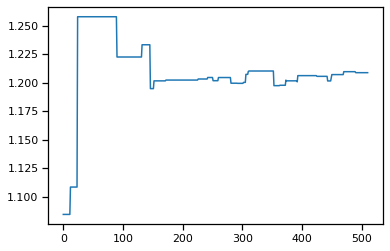

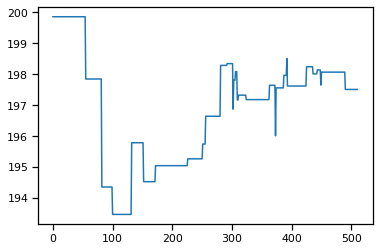

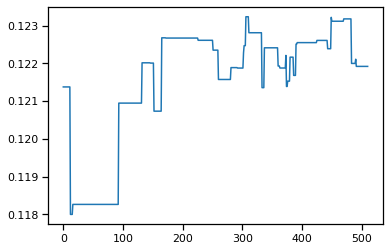

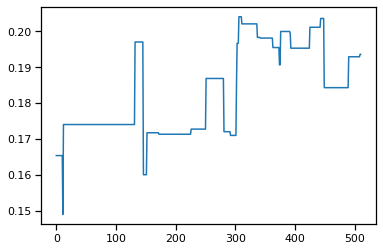

In [12]:
# the second (phase.scale) parameter
print(samples.shape)
walker = 0
for i in range(samples.shape[2]):
    plt.figure()
    plt.plot(samples[:, walker, i])

(3577, 7)

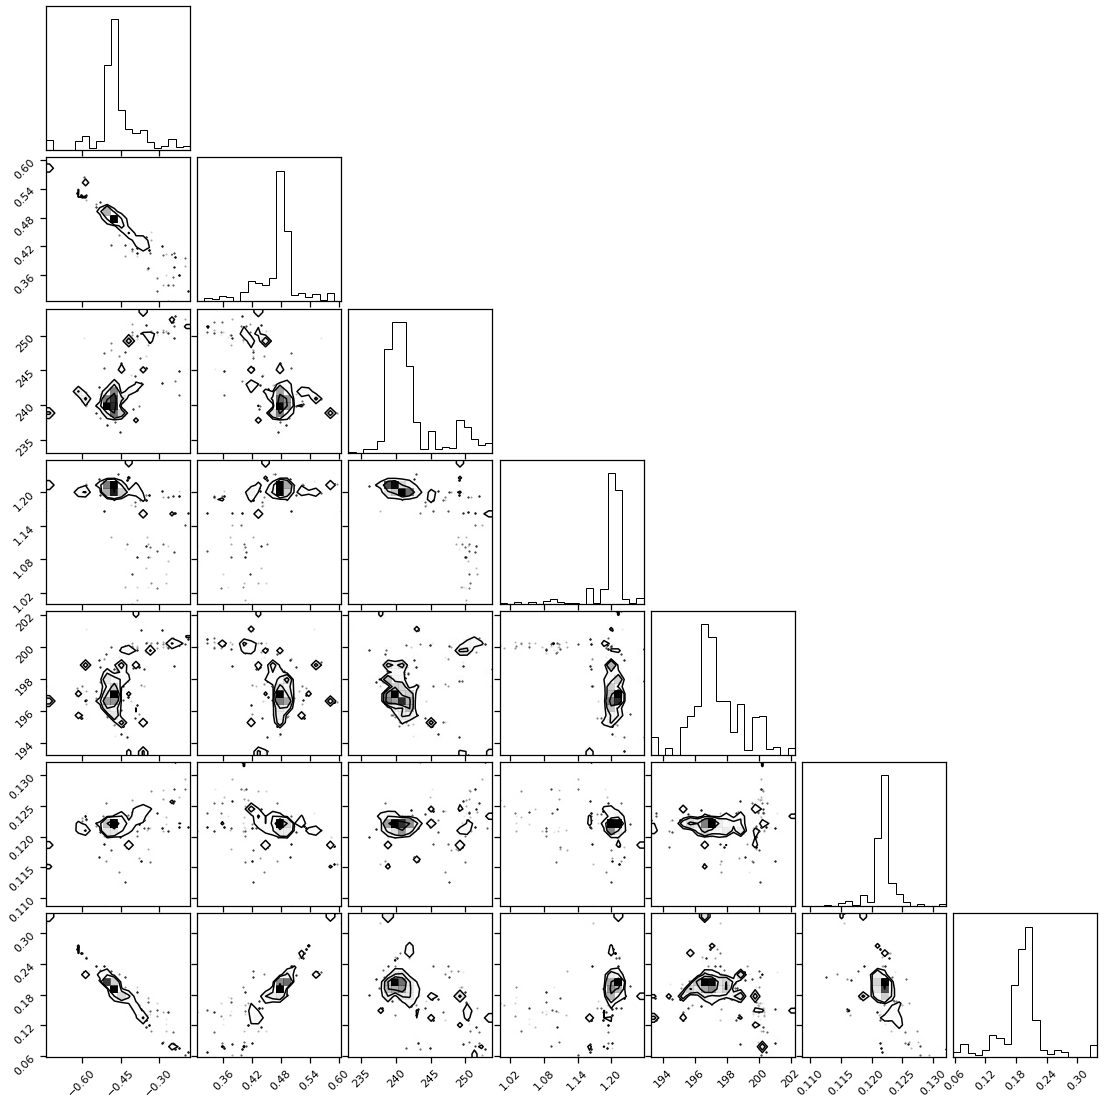

In [13]:
import corner
corner.corner(samples_flat);

samples_flat.shape

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 p103996675068078428256957165594636099134 -0.463(90)  -0.476  -0.485 [  -0.50   -0.39] [  -0.74   -0.24]
 2 p115130398186402342168768027308051150371  0.471(43)   0.478   0.485 [   0.43    0.49] [   0.36    0.59]
 3 p26851921218028266521610302375394125362  242.2(39)  240.90  240.00 [  239.2   246.1] [  238.0   252.0]
 4 p288274559095425807889621236863919536742  1.198(31)   1.204   1.208 [   1.19    1.21] [   1.09    1.22]
 5 p28930811549294052832347709268866444026  197.4(16) 197.089 196.923 [ 196.08  199.09] [ 193.57  200.49]
 6 p58761998728139009870481080864610135086 0.1219(21) 0.12192 0.12237 [ 0.1210  0.1228] [ 0.1161  0.1259]
 7 p97628043528038207855652635674368028100  0.190(44)   0.194   0.198 [   0.16    0.21] [   0.07    0.34]

Statistics and plots based on 3577 samples (100.0% of total samples drawn)


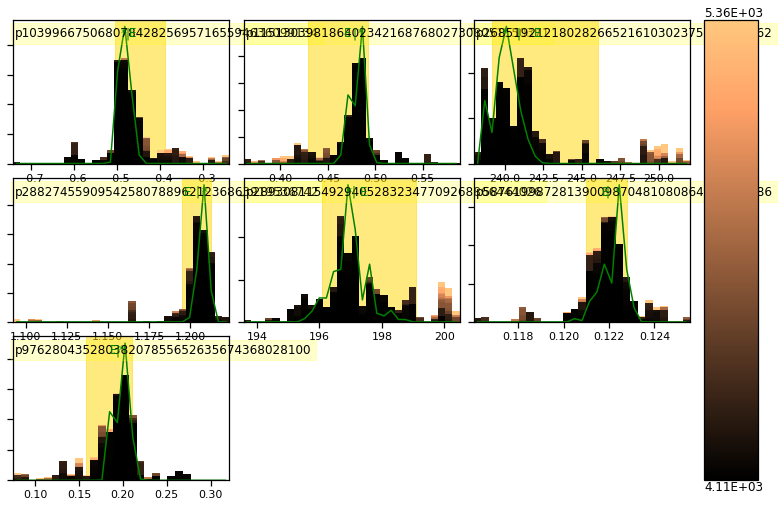

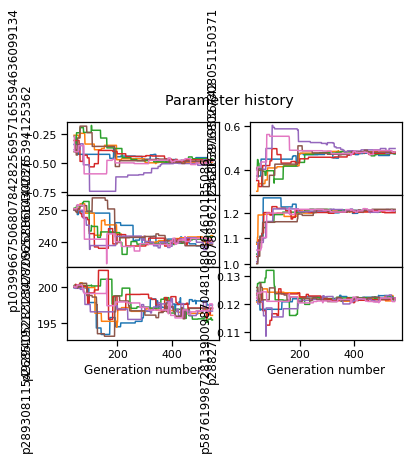

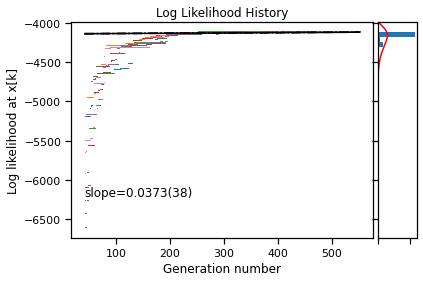

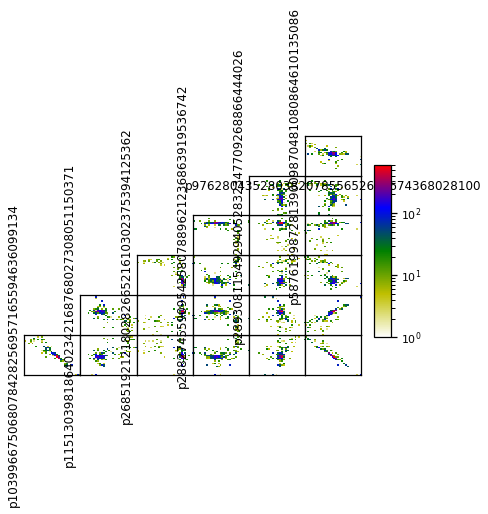

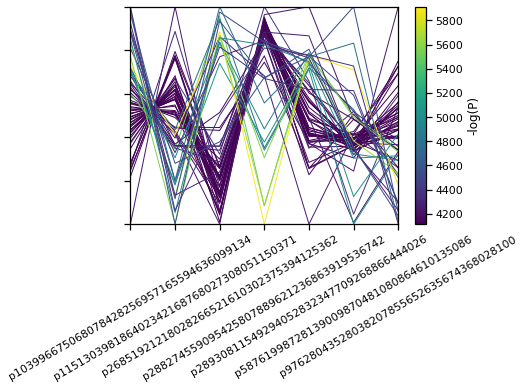

In [14]:
state.show()
